STEP 0 PROBLEM STATEMENT

1. In this project we wil build , train and test a model to classify fashion items using TF 2.0 
2. We will deploy the model in practice using Tensorflow Serving
3. Fashion training sets consist of 70,000 images divided into 60,000 training and 10,000 testing samples. Data set consist of 28*28 grayscale image , associated with a label from 10 classes

1. The 10 classes are
   - T shirt / Top
   - Trouser
   - Pullover
   - Dress
   - Coat 
   - Sandal
   - Shirt
   - Sneaker
   - Bag
   - Ankle Boot

Each images is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total

# Import Packages

In [1]:
import tensorflow as tf
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile

In [2]:
tf.__version__

'2.1.0'

# Import DataSet

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
# Data Normalization -> Between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(60000, 28, 28) (10000, 28, 28) 60000 10000


In [6]:
# Reshape training data to be (60000, 28, 28, 1) instead of (60000, 28, 28)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [7]:
X_train.shape

(60000, 28, 28, 1)

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',  'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

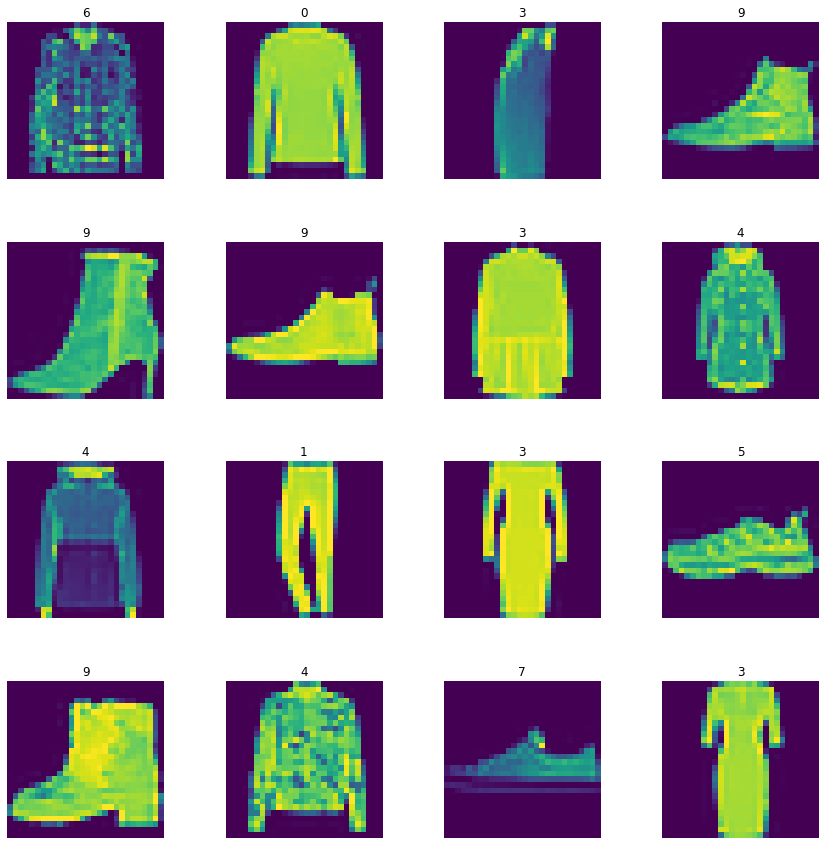

In [9]:
W_grid = 4
L_grid = 4

fig, axes =plt.subplots(L_grid, W_grid, figsize=(15, 15))
axes =axes.ravel()

n_training = len(X_train)

for i in np.arange(0, L_grid * W_grid):
  index= np.random.randint(0, n_training)  #pick a random number
  axes[i].imshow(X_train[index].reshape(28, 28))
  axes[i].set_title(y_train[index])
  axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4)

# Build , Train and Test the model

In [10]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (28, 28, 1)))
cnn.add(tf.keras.layers.MaxPooling2D(2,2))

cnn.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(64, activation='relu'))
cnn.add(tf.keras.layers.Dense(10, activation='softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                495680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 515,146
Trainable params: 515,146
Non-trainable params: 0
__________________________________________________

In [11]:
epochs = 5
cnn.compile(optimizer=  tf.compat.v1.train.AdamOptimizer(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
cnn.fit(X_train, y_train, epochs=epochs)

test_loss, test_acc = cnn.evaluate(X_test, y_test)
print('\nTest accuracy: {}'.format(test_acc))

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.4111 - accuracy: 0.8529
Epoch 2/5
60000/60000 [==============================] - 55s 909us/sample - loss: 0.2613 - accuracy: 0.9045
Epoch 3/5
60000/60000 [==============================] - 54s 908us/sample - loss: 0.2161 - accuracy: 0.9204
Epoch 4/5
60000/60000 [==============================] - 54s 898us/sample - loss: 0.1814 - accuracy: 0.9330
Epoch 5/5
10000/10000 [==============================] - 4s 374us/sample - loss: 0.2457 - accuracy: 0.9134

Test accuracy: 0.9133999943733215


# SAVE THE MODEL
1. We will save our model in SavedModel format
2. The model will have a version number and will be saved in a structured directory
3. tf.saved_model.simple_save is a function used to build a saved model that is suitable for serving using Tensorflow Serving
4. After the model is saved, we can use TensorFlow serving to start making inference requests using a specific version of our trained model "servable"
5. Use SavedModel to save and load your model- variables, the graph, and the graphs's metadata
6. This is a language neutral, recoverable, hermetic serialization format that enables higher-level systems and tools to produce, consume, and transform TensorFlow models.
7. simple_save offers a very easy way to save a model as follows
  - simple_save(session,
  - export_dir, inputs={"x":x, "y":y},
  - outputs={"z":z})

In [14]:
Model_Directory = '/home/pytorch_ashish/deep_learning/model/1/'

In [16]:
#Lets save the model using simple_save
if os.path.isdir(Model_Directory):
  print('\nAlready exist, Clean Up')
  !rm -r {Model_Directory}

tf.saved_model.save(cnn, Model_Directory)
   # tf.keras.backend.get_session(),  #get my session which is just created while fitting cnn
   # export_path,
   # inputs={'input_image': cnn.input},
   # outputs={i.name: i for i in cnn.outputs}
#)


Already exist, Clean Up
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/pytorch_ashish/deep_learning/model/1/assets


In [17]:
!ls -l {Model_Directory}

total 0
drwxrwxrwx 1 root root      0 Mar 21 03:11 assets
-rwxr-xr-x 1 root root 120460 Mar 21 03:11 saved_model.pb
drwxrwxrwx 1 root root      0 Mar 21 03:11 variables


# Explore our Saved Model
1. saved_model_cli will be used to explore MetaGraphDefs (the models) and SignatureDefs (the methods you can call) in our SavedModel
2. A MetaGraph is a dataflow graph, plus its associated variables, assets, and signatures
3. A signature is set of inputs to and outputs from a graph

In [18]:
!saved_model_cli show --dir {Model_Directory} --tag_set serve --signature_def serving_default


The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28, 1)
      name: serving_default_conv2d_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


# SERVE THE MODEL USING TENSORFLOW SERVING
1. Pull the docker image to serve the MODEL
    - docker pull tensorflow/serving
2. Run the docker image
    - docker run -p 5050:8501 --mount type=bind,source=/d/DockerData/BindMount/tf_serve/cnn,target=/models/cnn -e MODEL_NAME=cnn -t -d tensorflow/serving
    - docker run -p {LOCAL_PORT}:8501 — mount type=bind,source={ABSOLUTE_PATH},target=/models/{MODEL_NAME} -e MODEL_NAME={MODEL_NAME} -t tensorflow/serving
    


# Lets Start Making request in tensorflow serving

In [10]:
def show(idx, title):
    plt.figure()
    plt.imshow(X_test[idx].reshape(28, 28))
    plt.title('\n\n{}'.format(title), fontdict={'size':16})

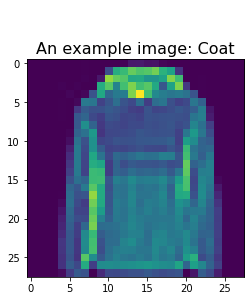

In [12]:
rando = random.randint(0, len(X_test) - 1)
show(rando, 'An example image: {}'.format(class_names[y_test[rando]]))

In [23]:
# Lets create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances":  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [24]:
import requests

In [25]:
headers = {"content-type":"application/json"}
json_response = requests.post('http://localhost:5050/v1/models/cnn:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

In [29]:
class_names[y_test[0]]

'Ankle Boot'

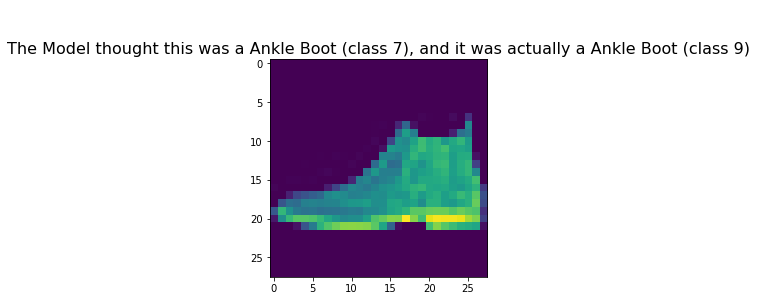

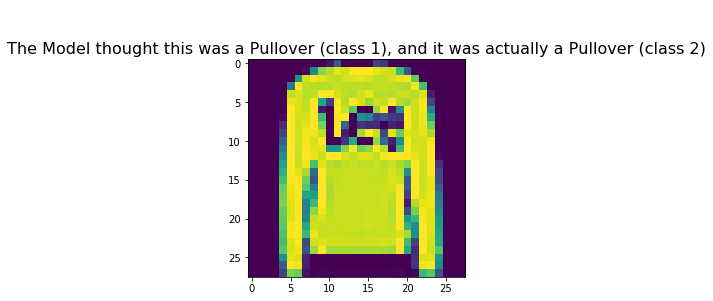

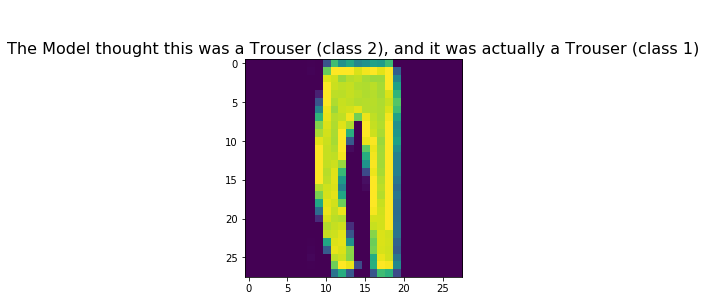

In [31]:
for i in range(3):
    show(i, 'The Model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
        class_names[np.argmax(predictions[i])], y_test[np.argmax(predictions[i])], class_names[y_test[i]], y_test[i]
    ))